In [14]:
cd ..

/Users/hyunminhong/Kalman-Heston-Filter


In [16]:
from src.KalmanFilterSV import MeasurementType, HestonKalmanFilter
from src.Heston import *
from filtering.filtering import particle_filter as pf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
# Set initial conditions and simulation parameters
S0 = 100
V0 = 0.04
params = {
    'mu': 0.05,
    'rho': -0.8,
    'kappa': 0.8,
    'theta': 0.04,
    'xi': 0.2
}
std_asy = np.sqrt(params['theta'] * params['xi']**2 / (2 * params['kappa']))
assert 2 * params['kappa'] * params['theta'] > params['xi']**2, "Feller condition is violated!"

Hest = Heston(**params)
time_daily, S_daily, daily_returns, daily_true_V, daily_RV = Hest.path_simulation(
    S0, V0, T_years=10, trading_days=252, intraday_intervals=39, seed=1
)
R_daily = daily_returns.copy()

resampling since: 945.4909591488216
resampling since: 1826.7920937952917
resampling since: 1181.0566603176533
resampling since: 675.7934955828147
resampling since: 2780.240451448685
resampling since: 3061.3838347616897
resampling since: 2137.440310829863
resampling since: 51.98577622640451
resampling since: 1994.3688103859513
resampling since: 2256.428600943392
resampling since: 1060.6718165920217
resampling since: 3297.47381724001
resampling since: 3060.8781489367248
resampling since: 3379.574512806127
resampling since: 2482.9210188256375
resampling since: 2573.587360837857
resampling since: 3074.322880752973
resampling since: 1447.78136946833
resampling since: 2511.111705062207
resampling since: 3203.074234384005
resampling since: 2192.0508266551788
resampling since: 2629.246757860277
resampling since: 2100.8232265255565
resampling since: 3396.2896204693393
resampling since: 2832.2417476805276
resampling since: 1861.009633194549
resampling since: 925.3982976959414
resampling since: 2

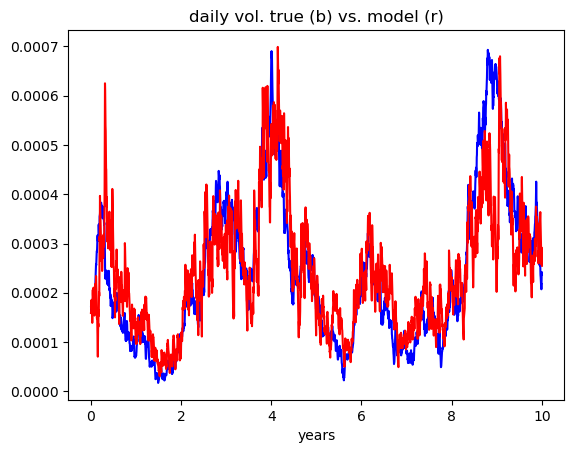

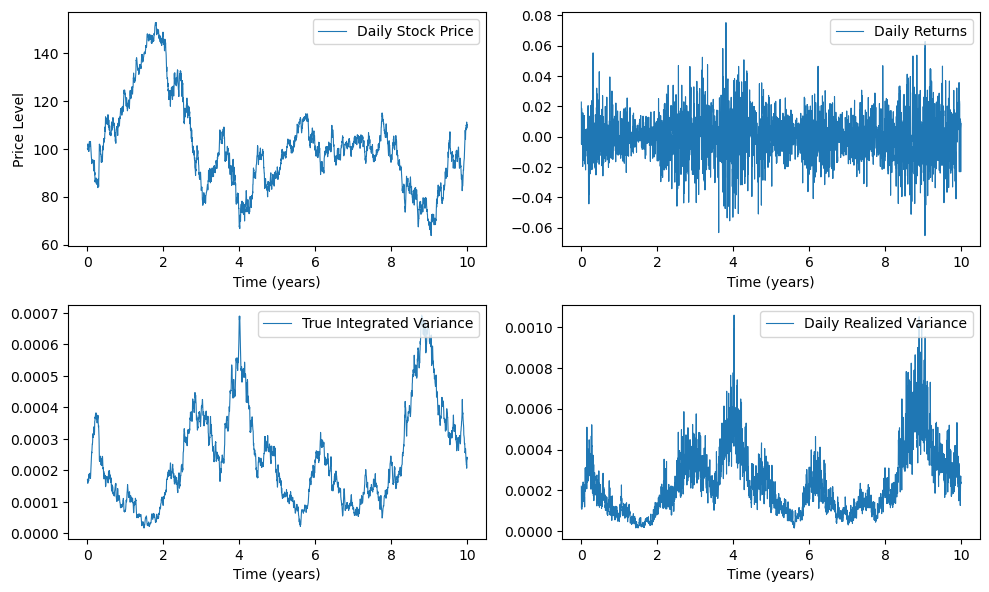

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# Subplot for BOTH measurements
axes[0,0].plot(time_daily, S_daily, label="Daily Stock Price", lw=0.8)
axes[0,0].set_xlabel("Time (years)")
axes[0,0].set_ylabel("Price Level")
axes[0,0].legend(loc="upper right")

# Subplot for RETURNS measurement
axes[0,1].plot(time_daily, daily_returns, label="Daily Returns", lw=0.8)
axes[0,1].set_xlabel("Time (years)")
axes[0,1].legend(loc="upper right")

# Subplot for RV measurement
axes[1,0].plot(time_daily, daily_true_V, label="True Integrated Variance", lw=0.8)
axes[1,0].set_xlabel("Time (years)")
axes[1,0].legend(loc="upper right")

# Subplot for RV measurement
axes[1,1].plot(time_daily, daily_RV, label="Daily Realized Variance", lw=0.8)
axes[1,1].set_xlabel("Time (years)")
axes[1,1].legend(loc="upper right")

plt.tight_layout()
plt.show()

In [22]:
burnin = 500
dt = 1  # Daily

# ============================================================================
# 1. BOTH Measurements: Uses both returns and RV
# ============================================================================

# Instantiate the Kalman filter for BOTH measurement type.
hkf_both = HestonKalmanFilter(measurement_type=MeasurementType.BOTH, dt=dt, V0=0.01, P0=0.1)
# Set the full data: filtering will be computed over all observations.
hkf_both.set_data(returns=R_daily, rv=daily_RV)
# For BOTH, parameter order is: [kappa, theta, xi, mu, sigma]
initial_params_both = np.array([0.001, 0.001, 0.001, 0.001, 0.001])
# Fit the model using the burnin (likelihood uses only t ≥ burnin).
fit_results_both = hkf_both.fit(initial_params=initial_params_both, burnin=burnin)
params_opt_both = fit_results_both['params']
print("Optimized parameters (BOTH):", params_opt_both)
# Retrieve filtered variance.
V_filt_both = hkf_both.get_filtered_variance()

# ============================================================================
# 2. RETURNS Measurement: Uses only returns data
# ============================================================================

hkf_returns = HestonKalmanFilter(measurement_type=MeasurementType.RETURNS, dt=dt, V0=0.01, P0=0.1)
# For returns-only, only return data is needed.
hkf_returns.set_data(returns=R_daily)
# Parameter order for RETURNS is: [kappa, theta, xi, mu]
initial_params_returns = np.array([0.001, 0.001, 0.001, 0.001])
fit_results_returns = hkf_returns.fit(initial_params=initial_params_returns, burnin=burnin)
params_opt_returns = fit_results_returns['params']
print("Optimized parameters (RETURNS):", params_opt_returns)
V_filt_returns = hkf_returns.get_filtered_variance()

# ============================================================================
# 3. RV Measurement: Uses only realized variance data
# ============================================================================

hkf_rv = HestonKalmanFilter(measurement_type=MeasurementType.RV, dt=dt, V0=0.01, P0=0.1)
# For RV-only, only the RV data is provided.
hkf_rv.set_data(rv=daily_RV)
# Parameter order for RV is: [kappa, theta, xi, sigma]
# initial_params_rv = np.array([0.8, 0.01, 0.001, 0.5])
initial_params_rv = np.array([0.001, 0.001, 0.001, 0.001])
fit_results_rv = hkf_rv.fit(initial_params=initial_params_rv, burnin=burnin)
params_opt_rv = fit_results_rv['params']
print("Optimized parameters (RV):", params_opt_rv)
V_filt_rv = hkf_rv.get_filtered_variance()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.16341D+04    |proj g|=  2.01000D-01

At iterate    1    f= -2.16398D+04    |proj g|=  2.00425D-01

At iterate    2    f= -2.16645D+04    |proj g|=  1.79722D+03

At iterate    3    f= -2.16751D+04    |proj g|=  2.81688D+04

At iterate    4    f= -2.16761D+04    |proj g|=  8.32940D+02

At iterate    5    f= -2.16772D+04    |proj g|=  1.04967D+03

At iterate    6    f= -2.16773D+04    |proj g|=  9.56284D+02

At iterate    7    f= -2.16773D+04    |proj g|=  7.79614D+02

At iterate    8    f= -2.16773D+04    |proj g|=  3.78755D+02

At iterate    9    f= -2.16776D+04    |proj g|=  1.62763D+02

At iterate   10    f= -2.16779D+04    |proj g|=  7.92189D+02

At iterate   11    f= -2.16780D+04    |proj g|=  1.99999D+00

At iterate   12    f= -2.16781D+04    |proj g|=  1.18741D+03

At iterate   13    f= -2.1


 Nonpositive definiteness in Cholesky factorization in formk;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f= -1.66816D+04    |proj g|=  4.23117D-03

At iterate    6    f= -1.66922D+04    |proj g|=  4.08985D-03

At iterate    7    f= -1.67019D+04    |proj g|=  1.87060D+04

At iterate    8    f= -1.67032D+04    |proj g|=  4.14580D+03

At iterate    9    f= -1.67032D+04    |proj g|=  2.52821D+03

At iterate   10    f= -1.67033D+04    |proj g|=  3.41782D+02

At iterate   11    f= -1.67033D+04    |proj g|=  1.99624D+00

At iterate   12    f= -1.67033D+04    |proj g|=  1.99624D+00

At iterate   13    f= -1.67034D+04    |proj g|=  1.99624D+00

At iterate   14    f= -1.67034D+04    |proj g|=  3.76251D-03

At iterate   15    f= -1.67035D+04    |proj g|=  3.76583D-03

At iterate   16    f= -1.67035D+04    |proj g|=  5.87996D+02

At iterate   17    f= -1.67035D+04    |proj g|=  1.43673D+03
  Positive dir derivative in projection 
  Using the backtracking step 

At iterate   18    f= -1.67035D+04    |proj g|=  9.86759D+02
  Positive dir derivative in projection 
  Using the backtra

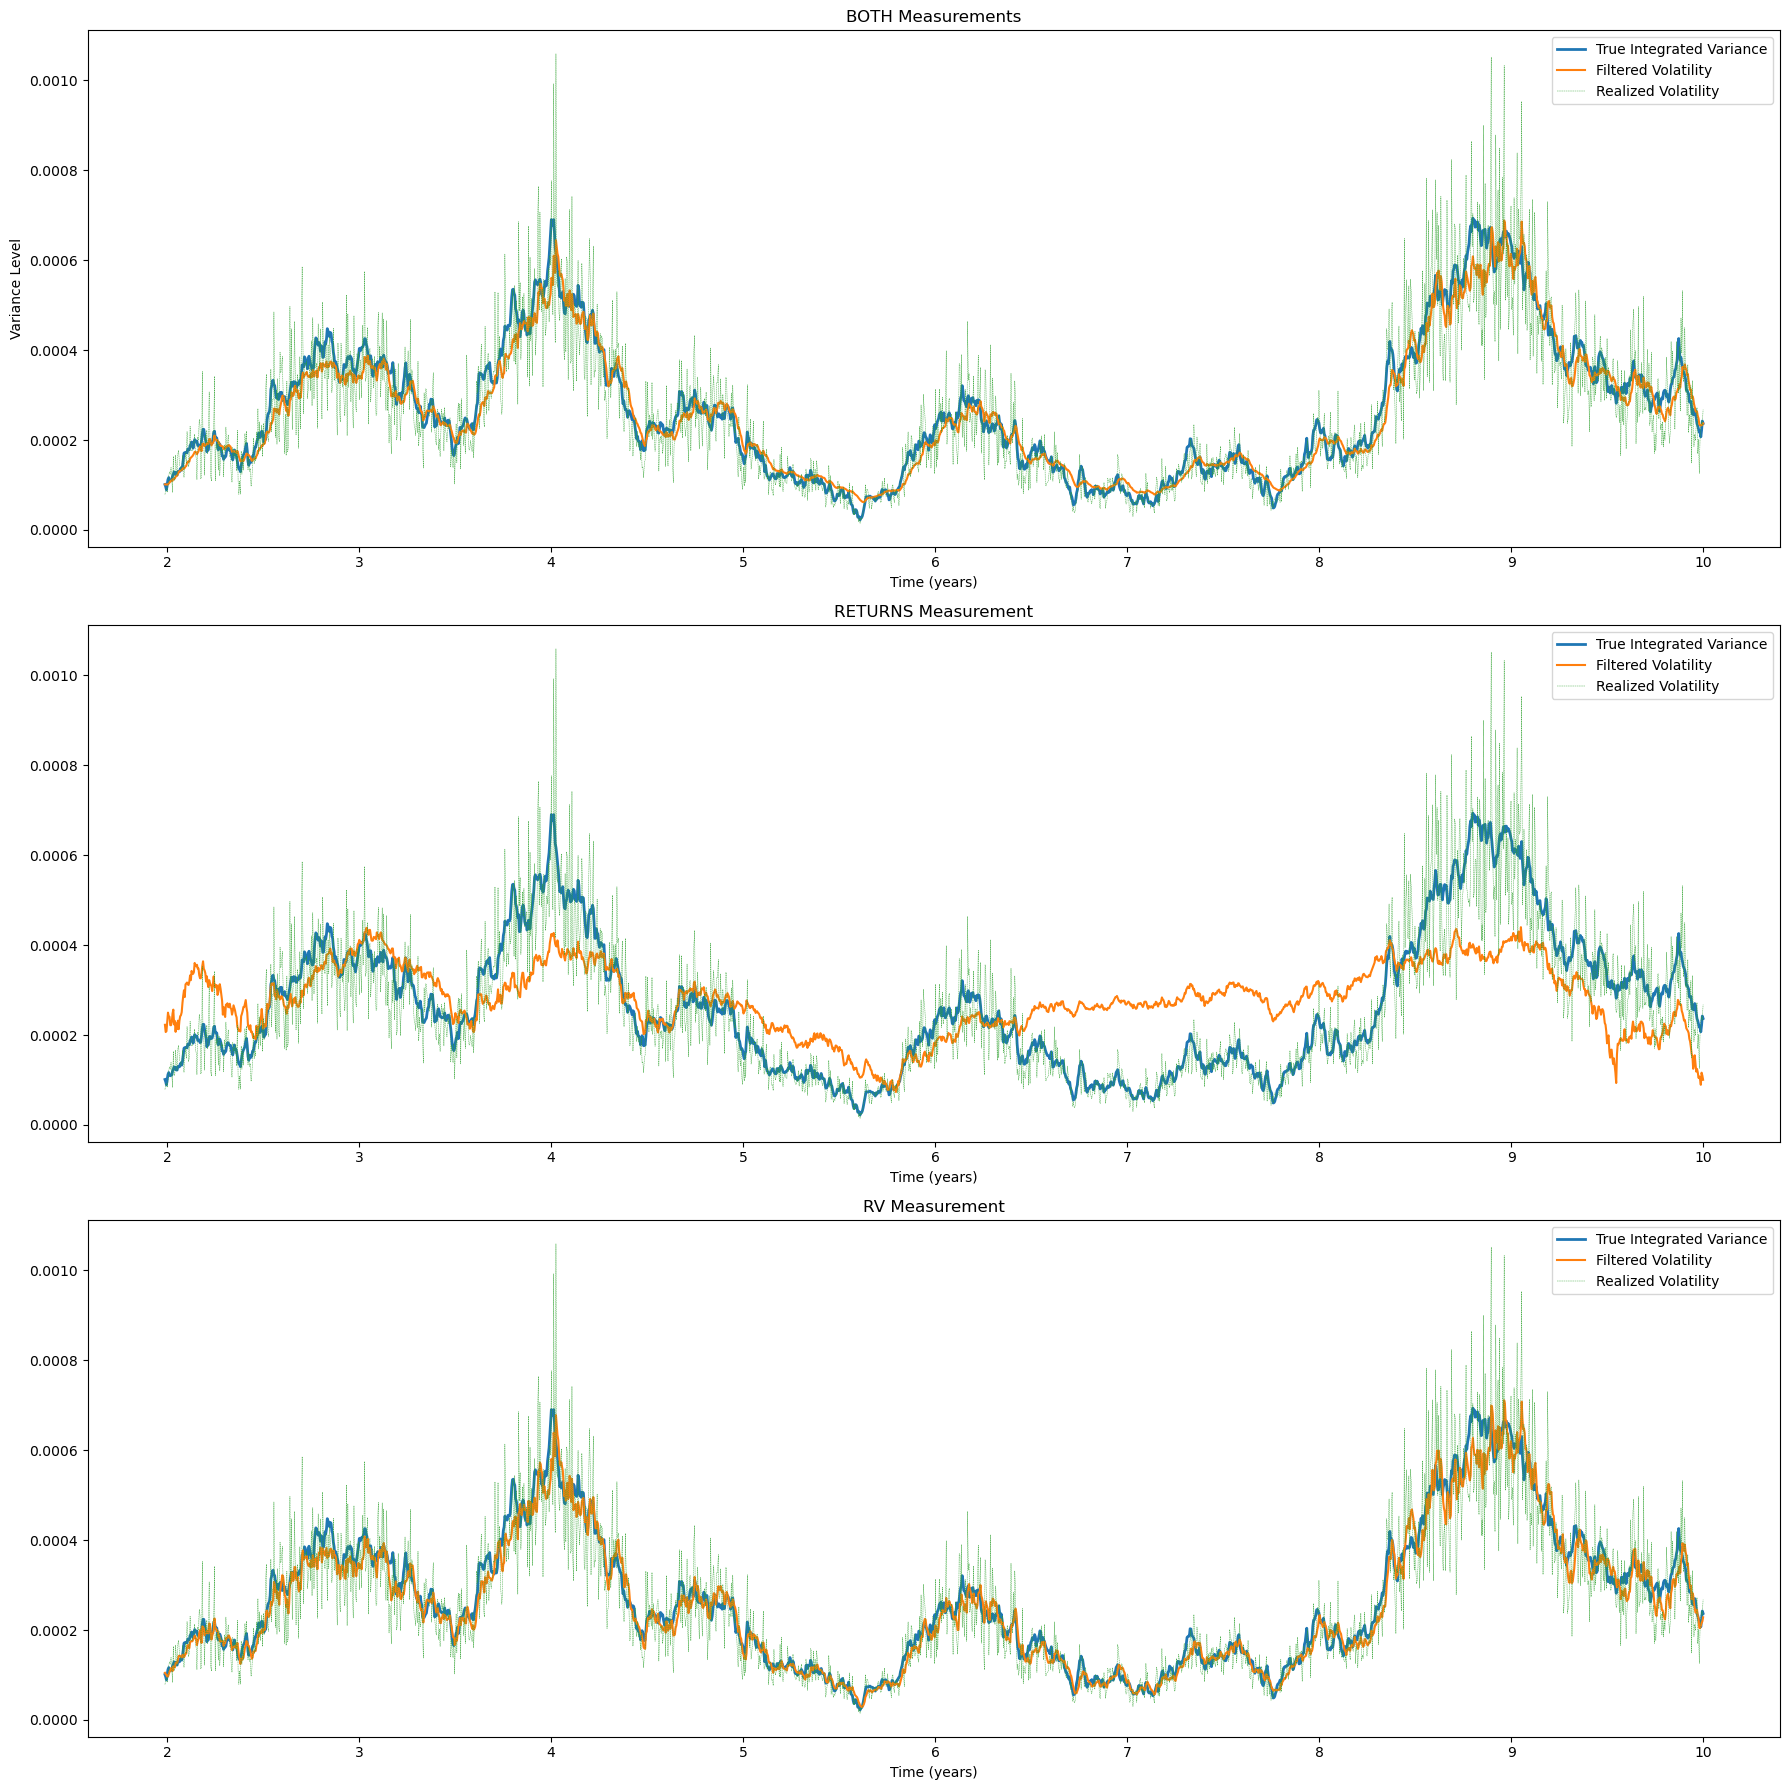

RMSE (BOTH - Filtered vs True): 0.000033
RMSE (RETURNS - Filtered vs True): 0.000115
RMSE (RV - Filtered vs True): 0.000030

--- Model Summary: BOTH ---

Heston Kalman Filter Summary
Measurement Type: both
Time Interval (dt): 1
Initial Variance (V0): 0.010000
Initial Covariance (P0): 0.100000

Fitted Parameters:
--------------------------------------------------
kappa: 0.003132
theta: 0.000313
xi: 0.000696
mu: -0.000185
sigma: 0.000025

Negative Log-Likelihood: -21678.239924
Convergence: True

AIC: -43346.479849
BIC: -43317.321762

--- Model Summary: RETURNS ---

Heston Kalman Filter Summary
Measurement Type: returns
Time Interval (dt): 1
Initial Variance (V0): 0.010000
Initial Covariance (P0): 0.100000

Fitted Parameters:
--------------------------------------------------
kappa: 0.003759
theta: 0.000654
xi: 0.002633
mu: -0.003084

Negative Log-Likelihood: -5450.703241
Convergence: True

AIC: -10893.406482
BIC: -10870.080013

--- Model Summary: RV ---

Heston Kalman Filter Summary
Meas

In [ ]:
# ============================================================================
# Plotting the Filtering Results Side-by-Side
# ============================================================================
burnin = 500

fig, axes = plt.subplots(3, 1, figsize=(18, 18))

# Subplot for BOTH measurements
axes[0].plot(time_daily[burnin:], daily_true_V[burnin:], label="True Integrated Variance", lw=2)
axes[0].plot(time_daily[burnin:], V_filt_both[burnin:], label="Filtered Volatility", lw=1.5)
axes[0].plot(time_daily[burnin:], daily_RV[burnin:], label="Realized Volatility", lw=0.3, linestyle="--")
axes[0].set_title("BOTH Measurements")
axes[0].set_xlabel("Time (years)")
axes[0].set_ylabel("Variance Level")
axes[0].legend(loc="upper right")

# Subplot for RETURNS measurement
axes[1].plot(time_daily[burnin:], daily_true_V[burnin:], label="True Integrated Variance", lw=2)
axes[1].plot(time_daily[burnin:], V_filt_returns[burnin:], label="Filtered Volatility", lw=1.5)
axes[1].plot(time_daily[burnin:], daily_RV[burnin:], label="Realized Volatility", lw=0.3, linestyle="--")
axes[1].set_title("RETURNS Measurement")
axes[1].set_xlabel("Time (years)")
axes[1].legend(loc="upper right")

# Subplot for RV measurement
axes[2].plot(time_daily[burnin:], daily_true_V[burnin:], label="True Integrated Variance", lw=2)
axes[2].plot(time_daily[burnin:], V_filt_rv[burnin:], label="Filtered Volatility", lw=1.5)
axes[2].plot(time_daily[burnin:], daily_RV[burnin:], label="Realized Volatility", lw=0.3, linestyle="--")
axes[2].set_title("RV Measurement")
axes[2].set_xlabel("Time (years)")
axes[2].legend(loc="upper right")

plt.tight_layout()
plt.show()

# ============================================================================
# Compute RMSE (Post Burnin)
# ============================================================================

true_post = daily_true_V[burnin:]
rmse_both = np.sqrt(np.mean((true_post - V_filt_both[burnin:]) ** 2))
rmse_returns = np.sqrt(np.mean((true_post - V_filt_returns[burnin:]) ** 2))
rmse_rv = np.sqrt(np.mean((true_post - V_filt_rv[burnin:]) ** 2))

print(f"RMSE (BOTH - Filtered vs True): {rmse_both:.6f}")
print(f"RMSE (RETURNS - Filtered vs True): {rmse_returns:.6f}")
print(f"RMSE (RV - Filtered vs True): {rmse_rv:.6f}")

# ============================================================================
# Print Model Summaries for Each Measurement Type
# ============================================================================

print("\n--- Model Summary: BOTH ---")
hkf_both.summary()

print("\n--- Model Summary: RETURNS ---")
hkf_returns.summary()

print("\n--- Model Summary: RV ---")
hkf_rv.summary()

resampling since: 2522.582785604623
resampling since: 304.03826826065597
resampling since: 144.64162247717348
resampling since: 548.667081733565
resampling since: 1689.4047728297685
resampling since: 2348.1390084796144
resampling since: 1178.9793955151283
resampling since: 657.3494507112405
resampling since: 621.4081925746239
resampling since: 597.6776399282348
resampling since: 2256.770218542654
resampling since: 4.845877814483208
resampling since: 1042.364102225657
resampling since: 2464.551437567261
resampling since: 2987.480479954
resampling since: 2571.1697752101286
resampling since: 800.1118792200862
resampling since: 2363.9153215680294
resampling since: 934.129821106852
resampling since: 1816.5283884131904
resampling since: 45.37261631513119
resampling since: 3347.2087164835484
resampling since: 3066.6595833801703
resampling since: 512.2337573244647
resampling since: 3365.662130276687
resampling since: 2909.115600553
resampling since: 2433.531319184313
resampling since: 2574.112

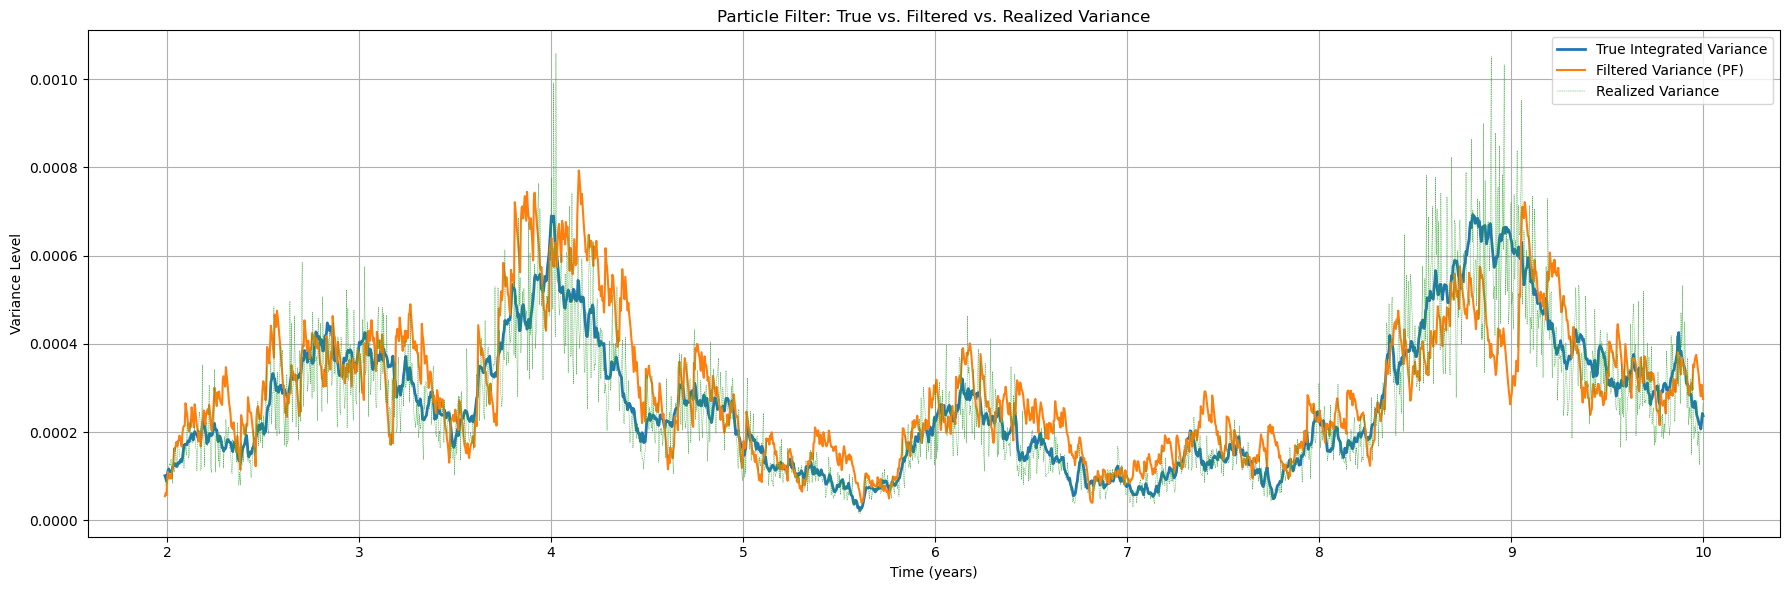

In [24]:
pf_heston = pf.PFHeston(np.log(S_daily), N=5000, is_log=True)

param_bounds = [
    (0.05, 0.5),   # mu
    (1, 9),        # kappa
    (0.05, 0.2),   # theta
    (0.01, 0.91),  # xi
    (-1, 0),       # rho
    V0             # v0
]

V_estimate, param_steps = pf_heston.filter(param_bounds, predict_obs=False)

# 2) Plot “true vs filtered vs realized” in Kalman style
burnin = 500

fig, ax = plt.subplots(1, 1, figsize=(18, 6))

ax.plot(time_daily[burnin:], daily_true_V[burnin:], label="True Integrated Variance", lw=2)
ax.plot(time_daily[burnin:], V_estimate[burnin:] / 252, label="Filtered Variance (PF)", lw=1.5)
ax.plot(time_daily[burnin:], daily_RV[burnin:], label="Realized Variance", lw=0.3, linestyle="--")

ax.set_title("Particle Filter: True vs. Filtered vs. Realized Variance")
ax.set_xlabel("Time (years)")
ax.set_ylabel("Variance Level")
ax.legend(loc="upper right")
ax.grid(True)

plt.tight_layout()
plt.show()

resampling since: 919.709542219076
resampling since: 954.2705717337165
resampling since: 1100.01819680209
resampling since: 1458.696405594023
resampling since: 322.69803721450603
resampling since: 77.85752574772476
resampling since: 344.53441072325415
resampling since: 1124.7471843972228
resampling since: 328.2591335759317
resampling since: 1032.1042118547753
resampling since: 735.1115768445912
resampling since: 2973.035879463853
resampling since: 2535.954986704254
resampling since: 1942.6553077263054
resampling since: 2558.091962504789
resampling since: 3413.401484782445
resampling since: 2123.6944105488265
resampling since: 1658.044526397564
resampling since: 2407.5173802221307
resampling since: 2792.5608758870576
resampling since: 2232.3482690914066
resampling since: 2444.846305422295
resampling since: 2678.356229379366
resampling since: 2581.0591541306926
resampling since: 3168.8172097261145
resampling since: 2648.9122781437436
resampling since: 3216.698526784197
resampling since: 

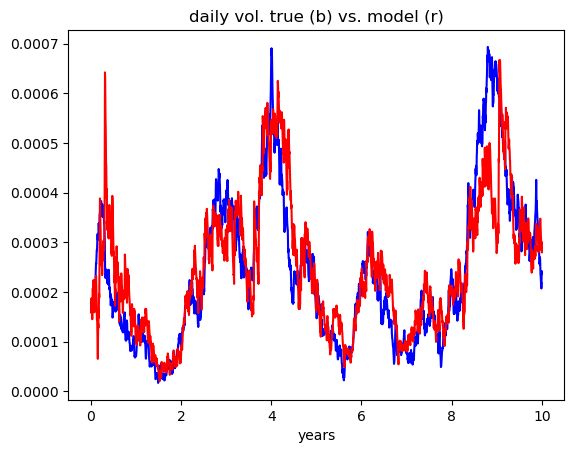

In [25]:
pf_heston = pf.PFHeston(np.log(S_daily), N=5000, is_log=True)

# lower/upper bounds for param. estimation
mu = (0.05, 0.5)
kappa = (1, 9)
theta = (0.05, 0.2)
xi = (0.01, 0.91)
rho = (-1, 0)
v0 = V0
params_ = [mu, kappa, theta, xi, rho, V0]

V_estimate, param_steps = pf_heston.filter(params_, predict_obs=False)

plt.plot(time_daily, daily_true_V, 'b-')
plt.plot(time_daily, V_estimate / 252, 'r-')
plt.title('daily vol. true (b) vs. model (r)')
plt.xlabel('years')
plt.show()